In [81]:
import os
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
from torchvision import transforms
from sklearn.model_selection import train_test_split
import math
from PIL import Image
from torchsummary import summary

In [2]:
!git clone https://github.com/n3slami/Hardware_Lab_Self_Driving_Car.git

Cloning into 'Hardware_Lab_Self_Driving_Car'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 78 (delta 33), reused 59 (delta 19), pack-reused 0
Unpacking objects: 100% (78/78), 34.26 KiB | 1.04 MiB/s, done.


In [3]:
%%capture
!gdown 1Y2Qxpoh6ja9YABKkJBS3N99EKw7-uU8c
!unzip 0531.zip

# Extract Boxes

In [4]:
sub_dirs = [dir for dir in os.walk('0531/')]

In [5]:
for dir in tqdm(sub_dirs[1:]):
  os.system(f'python3 Hardware_Lab_Self_Driving_Car/label_manager.py {dir[0]}')

100%|██████████| 358/358 [05:39<00:00,  1.05it/s]


In [6]:
!mkdir lane_images

In [7]:
def crop_lane(img, lane_desc):
  right = int(lane_desc[:,0].max())
  left = int(lane_desc[:,0].min())
  top = int(lane_desc[:,1].max())
  bottom = int(lane_desc[:,1].min())
  return img[bottom:top, left:right]

In [8]:
NUMBER_IMAGE = 20
HORIZON_RATIO = 0.35

idx = 0
y = []

for dir in tqdm(sub_dirs[1:]):
  try:
    for i in range(1, NUMBER_IMAGE+1):
      img = cv2.imread(f"{dir[0]}/{i}.jpg")
      img = img[int(img.shape[0] * HORIZON_RATIO):, :]
      lanes = np.load(f'{dir[0]}/lane_samples{i}.npy')
      labels = np.load(f'{dir[0]}/lane_labels{i}.npy')

      for j, lane in enumerate(lanes):
        cropped_lane = crop_lane(img, lane)
        if len(img):
          cv2.imwrite(f'lane_images/{idx}.jpg', cropped_lane)
          y.append(labels[j])
          idx += 1
  except Exception as e:
    pass

100%|██████████| 358/358 [00:55<00:00,  6.47it/s]


In [9]:
y[-5:], y[:5] 

([1, 0, 0, 0, 0], [2, 0, 0, 0, 0])

In [10]:
!ls

0531	  Hardware_Lab_Self_Driving_Car  lane_images
0531.zip  label_data_0531.json		 sample_data


In [11]:
!ls lane_images/ | head

0.jpg
1000.jpg
1001.jpg
1002.jpg
1003.jpg
1004.jpg
1005.jpg
1006.jpg
1007.jpg
1008.jpg


(231, 153, 3)


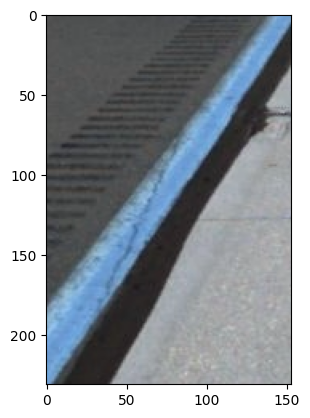

(231, 351, 3)


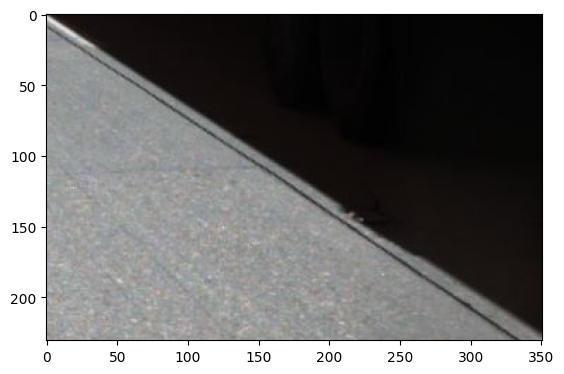

(231, 133, 3)


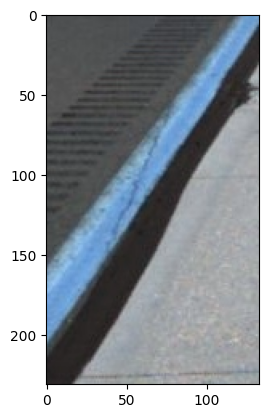

(231, 284, 3)


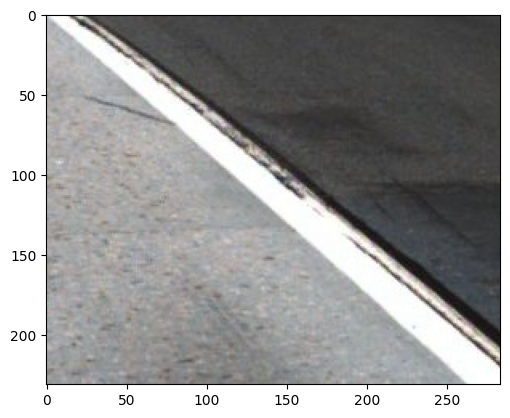

(231, 216, 3)


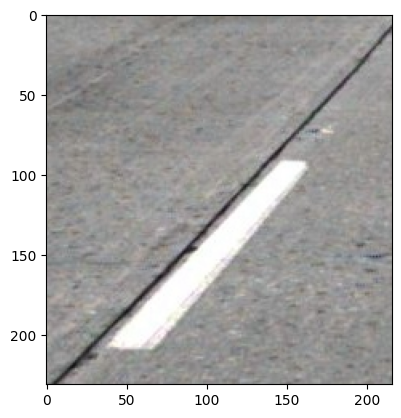

(231, 379, 3)


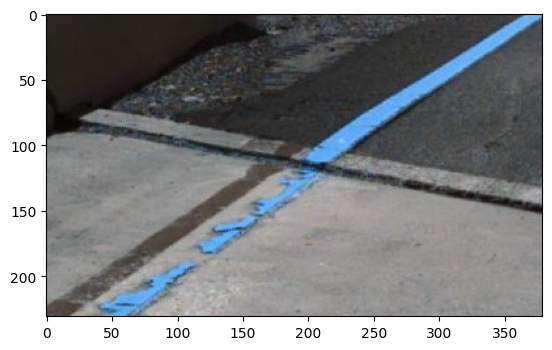

In [12]:
img = cv2.imread(f"lane_images/{6929}.jpg")
plt.imshow(img)
print(img.shape)
plt.show()

img = cv2.imread(f"lane_images/{6928}.jpg")
plt.imshow(img)
print(img.shape)
plt.show()

img = cv2.imread(f"lane_images/{6927}.jpg")
plt.imshow(img)
print(img.shape)
plt.show()

img = cv2.imread(f"lane_images/{0}.jpg")
plt.imshow(img)
print(img.shape)
plt.show()

img = cv2.imread(f"lane_images/{1}.jpg")
plt.imshow(img)
print(img.shape)
plt.show()

img = cv2.imread(f"lane_images/{2}.jpg")
plt.imshow(img)
print(img.shape)
plt.show()

# Dataset

In [26]:
X = []
for i in tqdm(range(len(y))):
    img = img = Image.open(f'lane_images/{i}.jpg').convert('RGB')
    X.append(img)
y = np.array(y)
print()
print(np.count_nonzero(y==0), np.count_nonzero(y==1), np.count_nonzero(y==2))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
print(np.count_nonzero(y_train==0), np.count_nonzero(y_train==1), np.count_nonzero(y_train==2))
print(np.count_nonzero(y_test==0), np.count_nonzero(y_test==1), np.count_nonzero(y_test==2))

100%|██████████| 6930/6930 [00:09<00:00, 718.54it/s]


4294 1473 1163
3220 1105 872
1074 368 291


In [27]:
class Lane(Dataset):
    def __init__(self, X, y, transform = transforms.Compose ([transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5))])):
        self.images = X
        labels = torch.Tensor(y).type(torch.LongTensor)
        self.labels = nn.functional.one_hot(labels, num_classes=3).type(torch.FloatTensor)
        self.transform = transform

    def __getitem__(self, index):
        return self.transform(self.images[index]), self.labels[index]

    def __len__(self):
        return len(self.images)


def get_dataset (X, y, transform = transforms.Compose([transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5))])):
    dataset = Lane(X, y, transform=transform)
    return dataset
    

def get_loader (X, y, transform = transforms.Compose([transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5))]), batch_size=128):
    dataset = get_dataset(X, y, transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Model

In [71]:
class CNNPredictor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.num_layers = 3
        self.layers = nn.ModuleList()
        input_size = 224
        kernel_size = 5
        stride = 2
        padding = 1
        self.layers.append(nn.Conv2d(3, 64, kernel_size, stride=stride, padding=padding))
        num_c = 64
        cnn_output_size = self.calc_output_size(input_size, kernel_size, stride, padding)
        for i in range(self.num_layers - 1):
            self.layers.append(nn.Conv2d(num_c, num_c * 2, kernel_size, stride=stride, padding=padding))
            num_c = num_c * 2
            cnn_output_size = self.calc_output_size(cnn_output_size, kernel_size, stride, padding)
        self.fc1 = nn.Linear(cnn_output_size * cnn_output_size * num_c, 128)
        self.fc2 = nn.Linear(128, 3)

    def calc_output_size(self, input_size, kernel_size, stride, padding):
        output_size = ((input_size - kernel_size + 2 * padding) / stride) + 1
        return int(math.floor(output_size))

    def forward(self, X):
        '''
        inputs:
            X: [batch_size, num_channels, input_height, input_width]
        outputs:
            temp: [batch_size, num_classes]
        '''
        temp = X
        for i in range(self.num_layers - 1):
            temp = self.layers[i](temp)
            temp = F.relu(temp)
        temp = self.layers[-1](temp)
        temp = torch.flatten(temp, start_dim=1)
        temp = self.fc1(F.relu(temp))
        temp = self.fc2(F.relu(temp))
        return temp

class ConvNet(nn.Module):
  def __init__(self, f_size):
    super(ConvNet, self).__init__()
    self.f_size = f_size
    self.conv1 = nn.Conv2d(3, 16, 5, stride=1, padding='same')
    self.conv2 = nn.Conv2d(16, 32, 5, stride=1, padding='same')
    self.conv3 = nn.Conv2d(32, 64, 5, stride=1, padding='same')
    self.fc1 = nn.Linear(f_size * f_size * 64, 64)
    self.fc2 = nn.Linear(64, 3)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, self.f_size * self.f_size * 64)
    x = F.relu(self.fc1(x))
    logits = self.fc2(x)
    return logits

In [62]:
summary(CNNPredictor().to('cuda'), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 111, 111]           4,864
            Conv2d-2          [-1, 128, 55, 55]         204,928
            Conv2d-3          [-1, 256, 27, 27]         819,456
            Linear-4                  [-1, 128]      23,888,000
            Linear-5                    [-1, 3]             387
Total params: 24,917,635
Trainable params: 24,917,635
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 10.40
Params size (MB): 95.05
Estimated Total Size (MB): 106.02
----------------------------------------------------------------


In [74]:
summary(ConvNet(192//8).to('cuda'), (3, 192, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 192, 192]           1,216
            Conv2d-2           [-1, 32, 96, 96]          12,832
            Conv2d-3           [-1, 64, 48, 48]          51,264
            Linear-4                   [-1, 64]       2,359,360
            Linear-5                    [-1, 3]             195
Total params: 2,424,867
Trainable params: 2,424,867
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.42
Forward/backward pass size (MB): 7.88
Params size (MB): 9.25
Estimated Total Size (MB): 17.55
----------------------------------------------------------------


# Train

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [64]:
seed = 10
torch.manual_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

In [91]:
def test_model(model, device, test_loader, set_name="test set"):
    criterion = nn.CrossEntropyLoss(reduction='sum')
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device).float(), target.to(device).float()
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = torch.argmax(output, dim=1)
            label = torch.argmax(target, dim=1)
            correct += pred.eq(label.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nPerformance on {}: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    set_name, test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

    return 100. * correct / len(test_loader.dataset), test_loss


def erm_train(model, device, train_loader, optimizer, epoch):
    criterion = nn.CrossEntropyLoss()
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device).float(), target.to(device).float()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))


def train_and_test_erm():
    print(f"ERM...\n")
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    print(device)

    img_size = 192
    mean, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    transform_train = transforms.Compose([
        transforms.RandomResizedCrop((img_size, img_size), scale=(0.05, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    transform_test = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    
    trainloader= get_loader (X_train, y_train, transform_train)
    testloader= get_loader (X_test, y_test, transform_test)    
    
    model = ConvNet(img_size//8).to(device)
    optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-5, momentum=0.9)
    
    train_acc = []
    train_loss = []
    test_acc = []
    test_loss = []
    path = '/content/drive/MyDrive/HardwareLab/checkpoint1/'
    f = open(os.path.join(path, 'log.txt'), 'w')
    for epoch in range(1, 151):
        erm_train(model, device, trainloader, optimizer, epoch)
        acc, loss = test_model(model, device, trainloader, set_name=f'train set epoch {epoch}')
        train_acc.append(acc)
        train_loss.append(loss)
        acc, loss = test_model(model, device, testloader, set_name=f'test set epoch {epoch}')
        test_acc.append(acc)
        test_loss.append(loss)
    f.write(str(train_acc))
    f.write('\n')
    f.write(str(test_acc))
    f.write('\n')
    f.write(str(train_loss))
    f.write('\n')
    f.write(str(test_loss))
    f.write('\n')
    f.close()
    torch.save(model, os.path.join(path, 'cnn.model'))

In [92]:
train_and_test_erm()

ERM...

cuda
Train Epoch: 1 [0/5197 (0%)]	Loss: 1.138270
Train Epoch: 1 [2560/5197 (49%)]	Loss: 1.088855
Train Epoch: 1 [3080/5197 (98%)]	Loss: 1.001642

Performance on train set epoch 1: Average loss: 0.9920, Accuracy: 3220/5197 (61.96%)


Performance on test set epoch 1: Average loss: 0.9883, Accuracy: 1074/1733 (61.97%)

Train Epoch: 2 [0/5197 (0%)]	Loss: 0.998008
Train Epoch: 2 [2560/5197 (49%)]	Loss: 1.029304
Train Epoch: 2 [3080/5197 (98%)]	Loss: 0.988306

Performance on train set epoch 2: Average loss: 0.9209, Accuracy: 3220/5197 (61.96%)


Performance on test set epoch 2: Average loss: 0.9185, Accuracy: 1074/1733 (61.97%)

Train Epoch: 3 [0/5197 (0%)]	Loss: 0.862617
Train Epoch: 3 [2560/5197 (49%)]	Loss: 0.864669
Train Epoch: 3 [3080/5197 (98%)]	Loss: 0.863205

Performance on train set epoch 3: Average loss: 0.8817, Accuracy: 3220/5197 (61.96%)


Performance on test set epoch 3: Average loss: 0.8745, Accuracy: 1074/1733 (61.97%)

Train Epoch: 4 [0/5197 (0%)]	Loss: 0.825320
Trai